# Классификация автомобилей по их изображению


## Автор: Petrochenkov Victor

### e-mail: 4941737@mail.ru

Задача:

> Дан набор данных с фотографиями автомобилей из 10 категорий. Задача заключается в выборе, настройке и точной настройке предварительно обученной модели для наиболее точных прогнозов категорий. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dl-car-classification/train.zip
/kaggle/input/sf-dl-car-classification/sample-submission.csv
/kaggle/input/sf-dl-car-classification/test.zip
/kaggle/input/sf-dl-car-classification/train.csv


In [2]:
# Настройки
!nvidia-smi
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor
!pip install efficientnet

Thu Jul  1 09:56:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Импортируем библиотеки
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import EfficientNetB7

from keras import backend as K

import efficientnet.tfkeras as efn

import sys
import pickle
import albumentations
import PIL

import csv
import zipfile
import shutil

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from ImageDataAugmentor.image_data_augmentor import *
from PIL import ImageOps, ImageFilter
from pylab import rcParams

import matplotlib.pyplot as plt
import seaborn as sns
rcParams['figure.figsize'] = 10, 5
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

Python       : 3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
Numpy        : 1.19.5
Tensorflow   : 2.4.1
Keras        : 2.4.0


In [4]:
# Установка условий расчётов 

EPOCHS               = 2  # эпох на обучение
BATCH_SIZE           = 64 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
INPUT_SHAPE          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

RANDOM_SEED          = 12

DATA_PATH = '../input/sf-dl-car-classification/'
PATH = "../working/car/" # рабочая директория

!pip3 freeze > requirements.txt

In [5]:
# Загружаем датасет

train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [6]:
# Просматриваем данные
train_df.head()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


<AxesSubplot:>

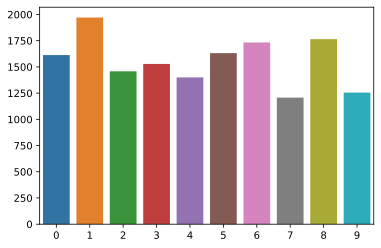

In [7]:
# Проверка частотного распределения данных по классам
sns.barplot(y=train_df.Category.value_counts().values,
            x=train_df.Category.value_counts().index)

In [8]:
# Распаковываем изображения
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile("../input/sf-dl-car-classification/"+data_zip,"r") as z:
        z.extractall(PATH)

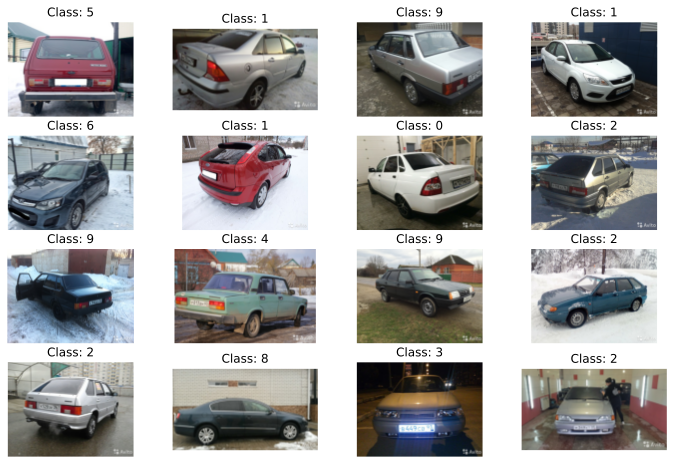

In [9]:
# Визуальный просмотр фото
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=16)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(4,4, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

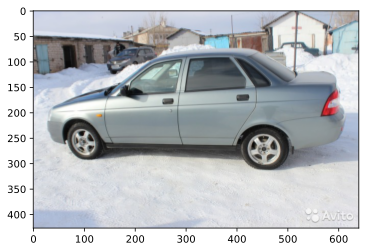

(640, 427)

In [10]:
# Просматриваем конкретное фото
image = PIL.Image.open(PATH+'/train/0/100155.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

>Итоги:

- Фотографии разделены на 10 категорий примерно одинакового размера;
- Фотографии размером 640 на 480 пикселей (в основном).
- В наборе обучающих данных 15561 фотография, а в тестовом наборе данных - 6675 фотографий.
- Количества фотографий недостаточно для обучения нашей нейронной сети, поэтому воспользуемся аугментацией. 

Воспользуемся генератором изображений IDA и библиотекой Albumentations, которая устанавливает для него гиперпараметры (угол поворота, размер кадрирования, яркость и т. Д.). 

In [11]:
# Создание условий для изменения.
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, 
                          interpolation=1, 
                          border_mode=4, 
                          value=None, 
                          mask_value=None, 
                          always_apply=False, 
                          p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=224, 
                                  width=200),
        albumentations.CenterCrop(height=200, 
                                  width=224),
    ],p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, 
                                                contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, 
                                                contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, 
                            always_apply=False, 
                            p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

In [12]:
# Загрузчики данных
train_datagen = ImageDataAugmentor(
    rescale=1./255,
    augment=AUGMENTATIONS,
    validation_split=VAL_SPLIT
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [13]:
# Генератор данных
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,
    subset='training'
)

valid_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='validation'
)

/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:332: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.


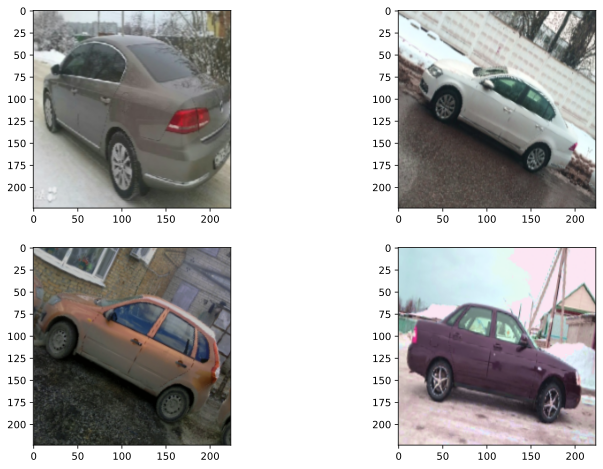

In [14]:
# Просматриваем результат трансформации фото
x,y = train_generator.next()

plt.figure(figsize=(12,8))

for i in range(0,4):
    image = x[i]
    plt.subplot(2,2, i+1)
    plt.imshow(image)
plt.show()

# Машинное обучение
## Оновная модель

In [15]:
# Загрузим модель EfficientNet B7. 
base_model = efn.EfficientNetB7(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE
)

258441216/258434480 [==============================] - 3s 0us/step


In [16]:
# Просматриваем архитектуру модели
# base_model.summary()

Фиксируем веса в базовой модели, чтобы мы не могли удалить функции, полученные в ImageNet в начале обучения. 

In [17]:
# Фиксируем веса
base_model.trainable = False

- Установим в качестве входа  базовую модель. 
- Оъединим все функции в один вектор через слой Average Pooling. 

In [18]:
# Добавление слоя
model = Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D(),)

Проведём эксперимент с архитектурой. Добавим еще один полностью связанный плотный, пакетный слой нормализации, выпадения и вывода. 

In [19]:
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(CLASS_NUM, activation='softmax'))

In [20]:
# Посмотрим на модель
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 7, 7, 2560)        64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               655616    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 64,756,890
Trainable params: 658,698
Non-trainable params: 64,098,192
______________________________________

In [21]:
# Просмотрим обучаемый статус отдельных слоев. 
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.functional.Functional object at 0x7fea461c84d0> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7fe990496e10> True
<tensorflow.python.keras.layers.core.Dense object at 0x7fe9904a9250> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fea14444c90> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7fe9904a98d0> True
<tensorflow.python.keras.layers.core.Dense object at 0x7fe9904a9e90> True


Добавим метрики качества и ошибок, а также алгоритм оптимизации скорости обучения Адама. 

In [22]:
# Компилируем модель
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(lr=LR),
    metrics=["accuracy"]
)


Добавим несколько функций обратного вызова. 
- ModelCheckpoint позволит нам сохранить прогресс обучения модели. 
- EarlyStopping останавливает обучение, если показатель качества не растет в течение количества эпох, равного параметру «терпение». 
- ReduceLROnPlateau снижает скорость обучения, если метрика потерь не падает в течение количества эпох, равного параметру «patience». 

In [23]:
# Формируем параметры функции обратного вызова 
checkpoint = ModelCheckpoint(
    'best_model.hdf5',
    monitor=['val_accuracy'],
    verbose=1,
    mode='max'
)

earlystop = EarlyStopping(
    monitor='accuracy',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.25,
    patience=2,
    min_lr=0.0000001,
    verbose=1,
    mode='auto'
)

callbacks_list = [
    checkpoint,
    earlystop,
    reduce_lr
]

In [24]:
# Тренеруем сформированную нейросеть
history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        validation_data=valid_generator, 
        validation_steps=valid_generator.samples//valid_generator.batch_size,
        epochs=EPOCHS,
        callbacks=callbacks_list)
#9^47

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
206/206 [==============================] - 218s 958ms/step - loss: 2.4973 - accuracy: 0.2274 - val_loss: 1.6129 - val_accuracy: 0.4601

Epoch 00001: saving model to best_model.hdf5
Epoch 2/2
206/206 [==============================] - 189s 916ms/step - loss: 1.8008 - accuracy: 0.3910 - val_loss: 1.2657 - val_accuracy: 0.5590

Epoch 00002: saving model to best_model.hdf5


Сохраним результат обучения модели, и загрузим веса из лучшей на данный момент итерации (best_model). 

In [25]:
# # Запись модели
model.save('../working/model_step1.hdf5')
# Загрузка весов
model.load_weights('best_model.hdf5')

Теперь проверим точность нашей модели и посмотрим на обучающие графики. 

In [26]:
# Просмотр точности модели - метрика accuracy.
scores = model.evaluate_generator(valid_generator, steps=len(valid_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


37/37 [==============================] - 28s 759ms/step - loss: 1.2710 - accuracy: 0.5620
Accuracy: 56.20%


## Точность этапа составляет:56.20%

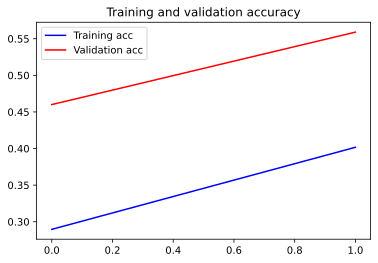

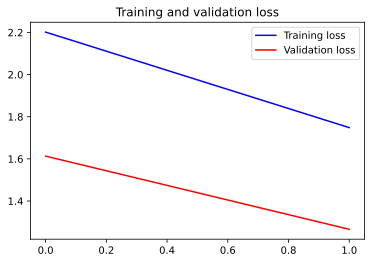

In [27]:
# Просмотр графиков обучения
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss'] 
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

# Настройка модели

Разморозим и проведём тренировку только половины весов.

In [28]:
# Разморозка всех слоёв
base_model.trainable = True

# Точная настройка слоя fine_tune_at
fine_tune_at = len(base_model.layers)//2

# Заморозка всех слоёв предшествующих слою fine_tune_at
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [29]:
# Компилируем модель
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(lr=LR),
    metrics=["accuracy"]
)

In [30]:
# Тренеруем сформированную нейросеть
history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        validation_data=valid_generator, 
        validation_steps=valid_generator.samples//valid_generator.batch_size,
        epochs=EPOCHS,
        callbacks=callbacks_list
)

Epoch 1/2
206/206 [==============================] - 250s 1s/step - loss: 1.9048 - accuracy: 0.3660 - val_loss: 0.6524 - val_accuracy: 0.7713

Epoch 00001: saving model to best_model.hdf5
Epoch 2/2
206/206 [==============================] - 221s 1s/step - loss: 0.8046 - accuracy: 0.7176 - val_loss: 0.3990 - val_accuracy: 0.8628

Epoch 00002: saving model to best_model.hdf5


In [31]:
# Запись модели
model.save('../working/model_step2.hdf5')
# Загрузка весов
model.load_weights('best_model.hdf5')

In [32]:
# Просмотр точности модели - метрика accuracy.
scores = model.evaluate_generator(valid_generator, steps=len(valid_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

37/37 [==============================] - 29s 764ms/step - loss: 0.3954 - accuracy: 0.8630
Accuracy: 86.30%


## Точность этапа составляет: 86.30%

# Настройка модели

Разморозим и проведём тренировку всей сети.

Уменьшим размер пакета и обновим генераторы данных, для того чтобы сеть поместилась в RAM GPU. 

In [33]:
# Уменьшение размера выборки.
BATCH_SIZE = 8

In [34]:
# Размораживаем все слои
base_model.trainable = True

In [35]:
# Генератор данных
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,
    subset='training'
)

valid_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='validation'
)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.


In [36]:
# Компилируем модель
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(lr=LR),
    metrics=["accuracy"]
)

In [37]:
# Тренеруем сформированную нейросеть
history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        validation_data=valid_generator, 
        validation_steps=valid_generator.samples//valid_generator.batch_size,
        epochs=EPOCHS,
        callbacks=callbacks_list
)

Epoch 1/2
1654/1654 [==============================] - 650s 375ms/step - loss: 0.8577 - accuracy: 0.7184 - val_loss: 0.2804 - val_accuracy: 0.8982

Epoch 00001: saving model to best_model.hdf5
Epoch 2/2
1654/1654 [==============================] - 617s 373ms/step - loss: 0.5018 - accuracy: 0.8344 - val_loss: 0.2054 - val_accuracy: 0.9291

Epoch 00002: saving model to best_model.hdf5


In [38]:
# Запись модели
model.save('../working/model_step3.hdf5')
# Загрузка весов
model.load_weights('best_model.hdf5')

## Точность этапа составляет: 92.91%

# Прогноз

Воспользуемся обученной сетью, чтобы предсказать категории в тестовом наборе данных.

In [39]:
# Генератор данных
test_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False,
    seed=RANDOM_SEED
)

Found 6675 validated image filenames.


In [40]:
# Просмотр данных
test_generator.samples

6675

In [41]:
# Прогнозированние данных
test_generator.reset()

predictions = model.predict_generator(
    test_generator, 
    steps=len(test_generator), 
    verbose=1
) 

predictions = np.argmax(
    predictions, 
    axis=-1)

label_map = (train_generator.class_indices)

label_map = dict((v,k) for k,v in label_map.items())

predictions = [label_map[k] for k in predictions]

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


835/835 [==============================] - 65s 74ms/step


In [42]:
# Настройка submission.
filenames_with_dir = test_generator.filenames

submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, 
                          columns=['Id', 'Category'])

submission['Id'] = submission['Id'].replace('test_upload/','')

submission.to_csv('submission.csv', index=False)

# Test Time Augmentation 

Дополним тестовые изображения и сделаем несколько прогнозов для одного и того же изображения, дополненного разными способами. Затем мы возьмем среднее значение этих прогнозов и, таким образом, получим окончательный прогноз. 

In [43]:
# Загрузка весов
model.load_weights('best_model.hdf5')

In [44]:
# Настройка условий для augmentation.
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, 
                          interpolation=1, 
                          border_mode=4, 
                          value=None, 
                          mask_value=None, 
                          always_apply=False, 
                          p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=224, 
                                  width=200),
        albumentations.CenterCrop(height=200, 
                                  width=224),
    ],p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, 
                                                contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, 
                                                contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, 
                            always_apply=False, 
                            p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

In [45]:
# Загружаем данные
test_datagen = ImageDataAugmentor( 
    rescale=1./255,
    augment=AUGMENTATIONS,
    validation_split=VAL_SPLIT,
)

In [46]:
# Генератор данных
test_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False,
    seed=RANDOM_SEED
)

Found 6675 validated image filenames.


/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:455: UserWarning: Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` '


In [47]:
# Прогнозирование данных
tta_steps = 10 
predictions = []

for i in range(tta_steps):
    preds = model.predict_generator(test_generator, 
                                    steps=len(test_generator), 
                                    verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

predictions = np.argmax(pred, axis=-1)

label_map = (train_generator.class_indices)

label_map = dict((v,k) for k,v in label_map.items())

predictions = [label_map[k] for k in predictions]

835/835 [==============================] - 81s 96ms/step


In [48]:
# Очистка данных
shutil.rmtree(PATH)

# Выводы

Осуществил:
* Инициализацию необходимых библиотек, задали условия визуализации и загрузили набор данных.
* Настроили гиперпараметры: количество эпох, размер пакета, скорость обучения, коэффициент проверочной выборки и размер изображения.
* Увеличили наши изображения несколькими способами, увеличив существенно размер выборки. 
* Загрузили предварительно обученную модель EfficientNet B7, изменили «голову», добавили слой пакетной нормализации и оптимизатор скорости обучения Адама.
* Настроили функции обратного вызова для сохранения промежуточного прогресса - остановки, если нет прогресса по метрике качества, и замедления скорости обучения, если нет прогресса по метрике потерь.
* Обучили модель трижды - с замороженными весами, предварительно натренированными в ImageNet, с половинными весами и со всеми весами.
* Предсказали наши данные стандартным способом и с помощью Test Time Augmentation. 

По результатам можно сделать следующие выводы: 
* Увеличение количества эпох улучшает результат, если не доводить его до переобучения.
* Уменьшение размера партии увеличивает время эксперимента, но помогает избежать ошибок ОЗУ.
* Низкая скорость обучения замедляет эксперимент, но помогает избежать локальных минимумов.
* Большой размер изображения замедляет эксперимент и перегружает оперативную память, но дает больше возможностей. * Увеличение изображения - хороший инструмент для увеличения размера выборки.
* Пошаговое обучение улучшает результаты, но не было значительной разницы между полуобученной и полностью обученной сетью.
* Очень важно следить за размером пакета, иначе обучение сети может быть прервано ошибкой ОЗУ. 
* Увеличение времени тестирования действительно улучшает результат предсказания. 
* Необходимо очистить выходной каталог на Kaggle, иначе ваш прогресс может не сохраниться. 
